# A/B test: från princip till praktik

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

np.random.seed(123)

In [9]:
baseline_rate_A = 0.26
true_lift_pp = 0.05
alpha_level = 0.05

sample_sizes_to_try = [50, 100, 150, 200, 300, 500, 800, 1320]

In [3]:
def run_one_ab_propotion_test(n_per_group, true_p_A, true_p_B, alternative="two-sided"):
    x_success_A = np.random.binomial(n_per_group, true_p_A)
    x_success_B = np.random.binomial(n_per_group, true_p_B)

    obs_p_A = x_success_A / n_per_group
    obs_p_B = x_success_B / n_per_group
    obs_diff = obs_p_B - obs_p_A

    pooled = (x_success_A + x_success_B) / (2 * n_per_group)

    se = np.sqrt(pooled * (1 - pooled) * (1 / n_per_group + 1 / n_per_group))

    z_value = obs_diff / se

    if alternative == "two-sided":
        p_value = 2 * (1 - stats.norm.cdf(abs(z_value)))
    elif alternative == "greater":
        p_value = 1 - stats.norm.cdf(z_value)
    else:
        p_value = stats.norm.cdf(z_value)

    return dict(
        x_success_A = x_success_A,
        x_success_B = x_success_B,
        obs_p_A = obs_p_A,
        obs_p_B = obs_p_B,
        obs_diff = obs_diff,
        z_value = z_value,
        p_value = p_value
    )


run_one_ab_propotion_test(
    100,
    baseline_rate_A,
    baseline_rate_A + true_lift_pp
)

{'x_success_A': 28,
 'x_success_B': 35,
 'obs_p_A': 0.28,
 'obs_p_B': 0.35,
 'obs_diff': 0.06999999999999995,
 'z_value': np.float64(1.0655712136475997),
 'p_value': np.float64(0.2866175177456791)}

In [4]:
n_demo = 300
res = run_one_ab_propotion_test(
    n_demo,
    baseline_rate_A,
    baseline_rate_A + true_lift_pp
)

p_A_hat, p_B_hat = res["obs_p_A"], res["obs_p_B"]
diff_hat = p_B_hat - p_A_hat

se_unpooled = np.sqrt(p_A_hat * (1 - p_A_hat) / n_demo + p_B_hat * (1 - p_B_hat) / n_demo)
z_crit = stats.norm.ppf(0.975)
ci_low_prop = diff_hat - z_crit * se_unpooled
ci_high_prop = diff_hat + z_crit * se_unpooled

(diff_hat, ci_low_prop, ci_high_prop), (p_A_hat, p_B_hat)

((0.07666666666666666,
  np.float64(0.0041872483782620235),
  np.float64(0.1491460849550713)),
 (0.25333333333333335, 0.33))

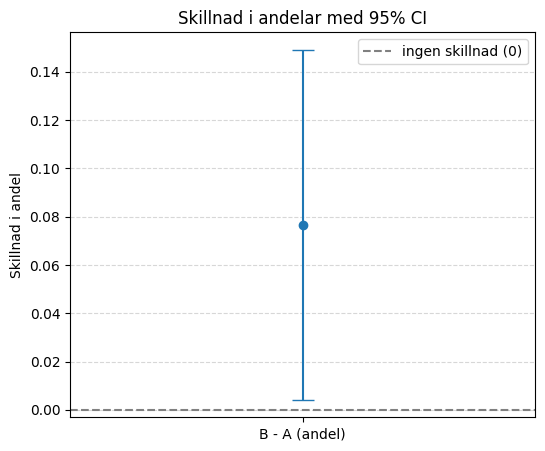

In [5]:
fig, ax = plt.subplots(figsize=(6,5))
ax.errorbar([0], [diff_hat], yerr=[[diff_hat - ci_low_prop], [ci_high_prop - diff_hat]], fmt="o", capsize=8)
ax.axhline(0, linestyle="--", color="gray", label="ingen skillnad (0)")
ax.set_xticks([0])
ax.set_xticklabels(["B - A (andel)"])
ax.set_ylabel("Skillnad i andel")
ax.set_title("Skillnad i andelar med 95% CI")
ax.grid(axis="y", linestyle="--", alpha=0.5)
ax.legend()
plt.show()

In [10]:
def estimate_power_by_simulation(n_per_group, true_p_A, true_p_B, alpha=0.05, alternative="two-sisded", num_simulations=5000):
    detections = 0
    for _ in range(num_simulations):
        res = run_one_ab_propotion_test(n_per_group, true_p_A, true_p_B, alternative)
        if res["p_value"] < alpha:
            detections += 1
    return detections / num_simulations

sim_power = []
for n in sample_sizes_to_try:
    pwr = estimate_power_by_simulation(n, baseline_rate_A, baseline_rate_A + true_lift_pp, alpha_level, "two-sided", 3000)
    sim_power.append(pwr)

pd.DataFrame({"n_per_group": sample_sizes_to_try, "simulated_power": sim_power})

,n_per_group,simulated_power
0,50,0.082333
1,100,0.121000
2,150,0.172000
3,200,0.196667
4,300,0.293000
5,500,0.409667
6,800,0.614333
7,1320,0.804667


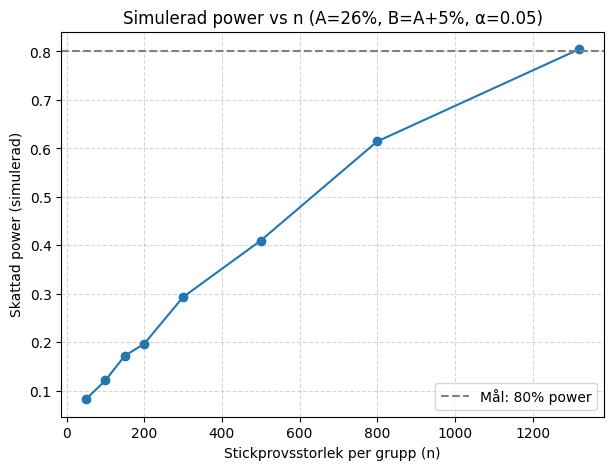

In [11]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(sample_sizes_to_try, sim_power, marker="o")
ax.axhline(0.8, color="gray", linestyle="--", label="Mål: 80% power")
ax.set_xlabel("Stickprovsstorlek per grupp (n)")
ax.set_ylabel("Skattad power (simulerad)")
ax.set_title(f"Simulerad power vs n (A={baseline_rate_A:.0%}, B=A+{true_lift_pp:.0%}, α={alpha_level})")
ax.grid(True, linestyle="--", alpha=0.5)
ax.legend()
plt.show()

In [8]:
def min_n_for_target_power_sim(true_p_A, true_p_B, alpha=0.05, target_power=0.8, n_low=20, n_high=5000, alternative="two-sided", num_sim=2000):
    low, high = n_low, n_high
    best = None
    while low <= high:
        mid = (low + high) // 2
        pwr = estimate_power_by_simulation(mid, true_p_A, true_p_B, alpha, alternative, num_sim)
        if pwr >= target_power:
            best = (mid, pwr)
            high = mid - 1
        else:
            low = mid + 1
    return best

min_n_estimate = min_n_for_target_power_sim(
    baseline_rate_A,
    baseline_rate_A + true_lift_pp,
    alpha_level,
    0.8,
    20,
    2000,
    "two-sided",
    1500
)

min_n_estimate

(1320, 0.822)

In [12]:
def power_vs_lift(n_per_group, lifts_pp, baseline_A = 0.26, alpha = 0.05):
    results = []
    for lift in lifts_pp:
        pwr = estimate_power_by_simulation(n_per_group, baseline_A, baseline_A + lift, alpha, "two-sided", 2000)
        results.append(pwr)
    return results

lifts_to_try = [0.02, 0.03, 0.05, 0.08, 0.10]
n_fixed = 300
pwr_by_lift = power_vs_lift(n_fixed, lifts_to_try, baseline_rate_A, alpha_level)

pd.DataFrame({"lift_pp": lifts_to_try, "power_at_n=300": pwr_by_lift})

,lift_pp,power_at_n=300
0,0.02,0.0820
1,0.03,0.1510
2,0.05,0.2685
3,0.08,0.5655
4,0.10,0.7525


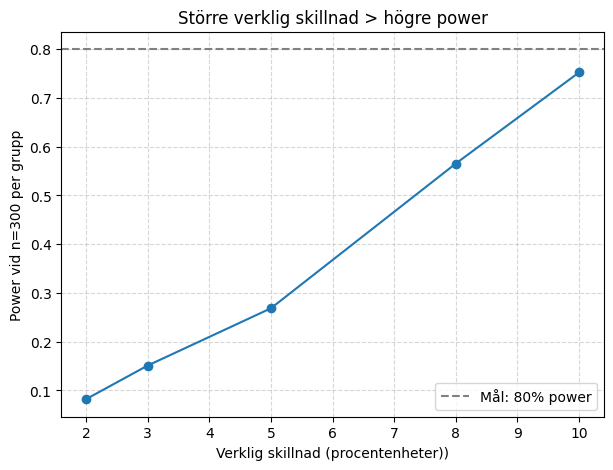

In [13]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot([100*l for l in lifts_to_try], pwr_by_lift, marker="o")
ax.axhline(0.8, color="gray", linestyle="--", label="Mål: 80% power")
ax.set_xlabel("Verklig skillnad (procentenheter))")
ax.set_ylabel("Power vid n=300 per grupp")
ax.set_title("Större verklig skillnad > högre power")
ax.grid(True, linestyle="--", alpha=0.5)
ax.legend()
plt.show()

In [14]:
def propability_of_any_false_alarm(num_tests, alpha=0.05, num_sim=5000):
    count_any = 0
    for _ in range(num_sim):
        pvals = np.random.rand(num_tests)
        if (pvals < alpha).any():
            count_any += 1
    return count_any / num_sim

tests_grid = [1, 2, 5, 10, 20, 50, 100]
risk_any = [propability_of_any_false_alarm(k, 0.05, 5000) for k in tests_grid]
pd.DataFrame({"antal_tester": tests_grid, "risk_minst_ett_falsklarm": risk_any})

,antal_tester,risk_minst_ett_falsklarm
0,1,0.0512
1,2,0.0950
2,5,0.2354
3,10,0.4130
4,20,0.6264
5,50,0.9198
6,100,0.9936


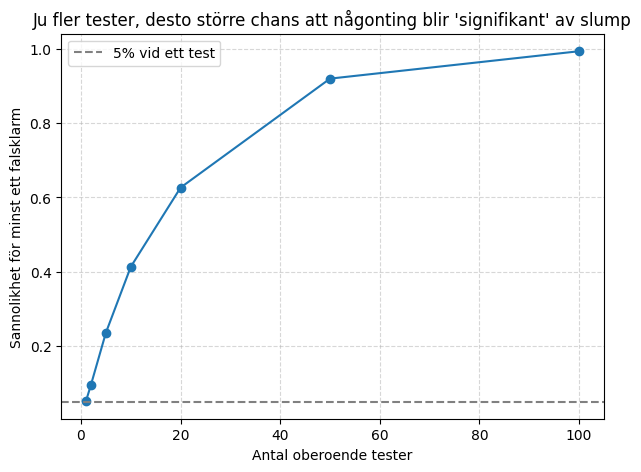

In [15]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(tests_grid, risk_any, marker="o")
ax.axhline(0.05, color="gray", linestyle="--", label="5% vid ett test")
ax.set_xlabel("Antal oberoende tester")
ax.set_ylabel("Sannolikhet för minst ett falsklarm")
ax.set_title("Ju fler tester, desto större chans att någonting blir 'signifikant' av slump")
ax.grid(True, linestyle="--", alpha=0.5)
ax.legend()
plt.show()

In [16]:
def bonferroni_corrected_alpha(alpha_global, num_tests):
    return alpha_global / num_tests

for k in [1, 5, 10, 20]:
    print(f"Antal tester = {k:>2} > använd gräns ≈ {bonferroni_corrected_alpha(0.05, k):.4f}")

Antal tester =  1 > använd gräns ≈ 0.0500
Antal tester =  5 > använd gräns ≈ 0.0100
Antal tester = 10 > använd gräns ≈ 0.0050
Antal tester = 20 > använd gräns ≈ 0.0025


In [34]:
from statsmodels.stats.proportion import proportions_ztest

n_A_prop, n_B_prop = 220, 240
true_p_A_demo, true_p_B_demo = 0.26, 0.31
A_outcomes = np.random.binomial(1, true_p_A_demo, size=n_A_prop)
B_outcomes = np.random.binomial(1, true_p_B_demo, size=n_B_prop)

df_prop = pd.DataFrame({
    "group": ["A"] * n_A_prop + ["B"] * n_B_prop,
    "outcome": np.concatenate([A_outcomes, B_outcomes])
})

counts = df_prop.groupby("group")["outcome"].agg(successes="sum", observations="count").reset_index()
x_A = counts.loc[counts.group == "A", "successes"].item()
n_A = counts.loc[counts.group == "A", "observations"].item()
x_B = counts.loc[counts.group == "B", "successes"].item()
n_B = counts.loc[counts.group == "B", "observations"].item()

z_stat, p_val = proportions_ztest(count=[x_A, x_B], nobs=[n_A, n_B], alternative="two-sided")

p_A = x_A / n_A
p_B = x_B / n_B
diff_pp = (p_B - p_A) * 100

z_stat, p_val, p_A, p_B, diff_pp

(np.float64(-0.4964179131933039),
 np.float64(0.6195995892600301),
 0.2545454545454545,
 0.275,
 2.0454545454545503)

In [35]:
from statsmodels.stats.proportion import proportion_confint, confint_proportions_2indep

ci_A_low, ci_A_high = proportion_confint(count=x_A, nobs=n_A, alpha=0.05, method="wilson")
ci_B_low, ci_B_high = proportion_confint(count=x_B, nobs=n_B, alpha=0.05, method="wilson")


diff_ci_low, diff_ci_high = confint_proportions_2indep(
    count1=x_B,
    nobs1=n_B,
    count2=x_A,
    nobs2=n_B,
    method="wald"
)

(ci_A_low, ci_A_high), (ci_B_low, ci_B_high), (diff_ci_low, diff_ci_high)

((0.20153739997479517, 0.31597825343008956),
 (0.22238857973715556, 0.3347006842365459),
 (np.float64(-0.0361441389379719), np.float64(0.11947747227130527)))

In [36]:
n_A_mean, n_B_mean = 120, 140
true_mu_A, true_mu_B = 50.0, 54.0
true_sd_A, true_sd_B = 10.0, 12.0

A_vals = np.random.normal(true_mu_A, true_sd_A, size=n_A_mean)
B_vals = np.random.normal(true_mu_B, true_sd_B, size=n_B_mean)

df_mean = pd.DataFrame({
    "group": ["A"] * n_A_mean + ["B"] * n_B_mean,
    "metric": np.concatenate([A_vals, B_vals])
})
df_mean.head()

,group,metric
0,A,62.139033
1,A,49.649192
2,A,51.745633
3,A,47.871456
4,A,34.340659


In [37]:
t_stat, p_val_two_sided = stats.ttest_ind(A_vals, B_vals, equal_var=False)

mean_A, mean_B = A_vals.mean(), B_vals.mean()
diff_mean = mean_B - mean_A

t_stat, p_val_two_sided, mean_A, mean_B, diff_mean

(np.float64(-2.9677518666182134),
 np.float64(0.0032820247848674745),
 np.float64(50.89339043746806),
 np.float64(54.946466065499344),
 np.float64(4.053075628031287))